# Programming Assignment 7. Exploring Grover's Search Algorithm

In this assignment, you will explore the behavior of Grover's search algorithm on problem instances of increasing size. The problem we'll consider is finding bit strings that consisting of alternating bit pairs.

## Questions

1. Implement the phase oracle for the given problem (2 points)
2. Optimize your solution (3 points) - you need to submit only one oracle for both tasks 1 and 2, the points in task 2 are assigned based on how optimized your submission is.
3. Find the optimal number of iterations for problem size N=3,4,5 (2 points) - submit the numbers you found and a brief description of the method you used to find them (possibly including the formulas). Note that your algorithm might not have 100% theoretical success probability at this number of iterations.
4. Run Grover's search for N=3,4,5 on noiseless Rigetti simulator (1 point) - submit the 3 plots you obtain.
5. Run Grover's search for N=3,4,5 on noisy Quantinuum simulator (2 points) - submit the 3 plots you obtain and a brief note of your thoughts on how they differ from the noiseless results. How would the results look like if you keep increasing the problem size?

In [7]:
import matplotlib.pyplot as plt
import qsharp


## Task 1. Implement the phase oracle (2 points)
First we need to define an oracle. 
For this example we will consider the function $f(x)$ which is equal to 1 when $x$ is a bit string of length $N$ in which odd pairs of adjacent bits are the same and even pairs differ. For any $N$ there will be two possible solutions, one starting with 0 and one starting with 1. So for this example the number of solutions is 2.

Our $f$ will look like this:
$$
f(x) =  \begin{cases} 
      1 & x = 00110011\text{... or }11001100\text{...}\\
      0 & \text{otherwise}
   \end{cases}
$$

In [8]:
%%qsharp
function BuildPattern(n : Int, flag: Bool) : Bool[] {
   mutable pattern = [];
   mutable flagElement = false;
   if flag == true {
      set flagElement = false;
   } else {
      set flagElement = true;
   }
   for i in 0..n-1 {
      if i % 2 == 0 {
         if flagElement == true {
            set flagElement = false;
         } else {
            set flagElement = true;
         }
      }
      set pattern = pattern + [flagElement];
   }
   return pattern;
}


In [9]:
%%qsharp

open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Math;

operation AlternatingBitPairsOracle(qs : Qubit[]) : Unit {
   let n = Length(qs);
   let pattern1100 = BuildPattern(n, true);
   let pattern0011 = BuildPattern(n, false);
    use q = Qubit();
    X(q);
    ApplyControlledOnBitString(pattern1100, Z, qs, q);
    ApplyControlledOnBitString(pattern0011, Z, qs, q);
    X(q);
}


You can use the following wrapper operation to print the effects your oracle has on the even superposition of basis states. 

**IMPORTANT**: depending on the version of `qsharp` package you're using, the output of `DumpMachine` will differ. Versions 1.0.34 and earlier reverse the order of qubits in the output, so if you run an oracle that correctly flips the phase of states $|110\rangle$ and $|001\rangle$ for a three-qubit state, DumpMachine will show them as $|011\rangle$ and $|100\rangle$. Versions 1.1 and later don't reverse the order of qubits, so the output will be as expected. You can check which version you're using from the notebook, by runinng `!pip list` in a separate cell and looking for `qsharp` package in the output.

In [4]:
%%qsharp
open Microsoft.Quantum.Diagnostics;

// The operation that applies the oracle to an even superposition of all inputs and prints the resulting state
operation DemoWrapper(N : Int) : Unit {
    use qs = Qubit[N];
    ApplyToEach(H, qs); 
    AlternatingBitPairsOracle(qs);
    DumpMachine();
    ResetAll(qs);
}


In [5]:
qsharp.eval("DemoWrapper(5)")


STATE:
|00000⟩: 0.1768+0.0000𝑖
|10111⟩: 0.1768+0.0000𝑖
|10000⟩: 0.1768+0.0000𝑖
|11101⟩: 0.1768+0.0000𝑖
|11110⟩: 0.1768+0.0000𝑖
|11011⟩: 0.1768+0.0000𝑖
|00100⟩: 0.1768+0.0000𝑖
|00001⟩: 0.1768+0.0000𝑖
|00010⟩: 0.1768+0.0000𝑖
|01111⟩: 0.1768+0.0000𝑖
|01000⟩: 0.1768+0.0000𝑖
|10100⟩: 0.1768+0.0000𝑖
|10001⟩: 0.1768+0.0000𝑖
|10010⟩: 0.1768+0.0000𝑖
|11111⟩: 0.1768+0.0000𝑖
|11000⟩: 0.1768+0.0000𝑖
|00101⟩: 0.1768+0.0000𝑖
|00110⟩: 0.1768+0.0000𝑖
|00011⟩: 0.1768+0.0000𝑖
|01100⟩: −0.1768+0.0000𝑖
|01001⟩: 0.1768+0.0000𝑖
|01010⟩: 0.1768+0.0000𝑖
|10101⟩: 0.1768+0.0000𝑖
|10110⟩: 0.1768+0.0000𝑖
|10011⟩: −0.1768+0.0000𝑖
|11100⟩: 0.1768+0.0000𝑖
|11001⟩: 0.1768+0.0000𝑖
|11010⟩: 0.1768+0.0000𝑖
|00111⟩: 0.1768+0.0000𝑖
|01101⟩: 0.1768+0.0000𝑖
|01110⟩: 0.1768+0.0000𝑖
|01011⟩: 0.1768+0.0000𝑖


## Task 2. How far can you optimize your solution? (3 points)

You can use the code below to estimate the resources required to run your solution. The scoring is done based on the case of $N = 5$.

* If your solution gets a score above 1500, you'll get 0 points.
* If your solution gets a score between 1000 and 1500, you'll get 1 point.
* If your solution gets a score between 500 and 1000, you'll get 2 points.
* If your solution gets a score under 500, you'll get 3 points.

In [6]:
%%qsharp
open Microsoft.Quantum.Measurement;
operation AlternatingBitPairsOracleWrapper(N : Int) : Result[] {
    use qs = Qubit[N];
    AlternatingBitPairsOracle(qs);
    return MeasureEachZ(qs);
}


In [7]:
# The function that extracts the relevant resource information from the resource estimation job results and produces your absolute score.
def evaluate_results(res) : 
    width = res['physicalCounts']['breakdown']['algorithmicLogicalQubits']
    depth = res['physicalCounts']['breakdown']['algorithmicLogicalDepth']
    print(f"Logical algorithmic qubits = {width}")
    print(f"Algorithmic depth = {depth}")
    print(f"Score = {width * depth}")
    return width * depth

est = qsharp.estimate("AlternatingBitPairsOracleWrapper(5)")
evaluate_results(est)


Logical algorithmic qubits = 28
Algorithmic depth = 59
Score = 1652


1652

### Task 3. Find the optimal number of iterations for $N = 3, 4, 5$ (2 points)

The next cell implements Grover's search algorithm that takes two parameters: the number of bits in the strings we're looking for, and the number of iterations to run the algorithm for before measurement. 

Your task is to calculate the optimal number of iterations for $N = 3, 4, 5$ based on the size of the search space and the known number of problem solutions.

In [10]:
%%qsharp
open Microsoft.Quantum.Measurement;
operation Grovers(N : Int, iterations : Int) : Result[] {
    use qs = Qubit[N];
    ApplyToEach(H, qs);

    for i in 1 .. iterations {
        AlternatingBitPairsOracle(qs);
        
        within {
            ApplyToEachA(H, qs);
            ApplyToEachA(X, qs);
        } apply {
            Controlled Z(qs[...N - 2], qs[N - 1]);
        }
    }
    let res = MeasureEachZ(qs);
    ResetAll(qs);
    return res;
}


You can run a single simulation to see whether the measurement produced a state that is a solution to our problem. 

In [9]:
qsharp.eval("Grovers(5, 1)")


[Zero, One, Zero, Zero, Zero]

You can also run a series of simulations on a local simulator to see the percentage of shots for which a query returns a correct answer.

In [10]:
N = 5
iterations = 6
target1 = [qsharp.Result.One if (i // 2) % 2 == 1 else qsharp.Result.Zero for i in range(N)]
target2 = [qsharp.Result.One if (i // 2) % 2 == 1 else qsharp.Result.Zero for i in range(2, N+2)]
shots = 100
correctCount = 0
results = qsharp.run(f"Grovers({N}, {iterations})", shots=shots)

for res in results:
    if res == target1 or res == target2:
        correctCount += 1

print(f"N={N}, iter={iterations} - {100 * correctCount/shots}% of queries returned a correct answer")


N=5, iter=6 - 1.0% of queries returned a correct answer


## Optimal Iterations

- The optimal number of iterations for \( N = 3 \) is 1 iteration.
- The optimal number of iterations for \( N = 4 \) is 6 iterations.
- The optimal number of iterations for \( N = 5 \) is 15 iterations.



## Tasks 4-5. Run Grover's search for $N = 3, 4, 5$ on noiseless Rigetti simulator (1 point) and noisy Quantinuum emulator (2 points)

* Run the Grover's search algorithm for the oracle you've implemented on Rigetti or IonQ noiseless simulator (`rigetti.sim.qvm` or `ionq.simulator`) for $N = 3, 4, 5$.
* Run the Grover's search algorithm for the oracle you've implemented on Quantinuum noisy emulator (`quantinuum.sim.h1-1e`) for $N = 3, 4, 5$.
* Plot the results in a 2x3 or 3x2 table to compare the results on the same problem instance side-by-side.

In [6]:
from azure.quantum import Workspace

workspace = Workspace(
            resource_id = "/subscriptions/f5293a35-391c-46ba-ac13-97278ebecdc4/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/CSYE6105",
            location = "eastus")

qsharp.init(target_profile=qsharp.TargetProfile.Base)


Q# initialized with configuration: {'targetProfile': 'base'}

**IMPORTANT:** After you call `qsharp.init`, you'll need to recompile the cells that define the oracle and Grover's search before proceeding.

In [15]:
# Select the target here
# target = workspace.get_targets("ionq.simulator")


## Simulator: rigetti.sim.qvm

In [15]:
target_rigetti = workspace.get_targets("rigetti.sim.qvm")

### For N =3 (rigetti.sim.qvm)

In [16]:
N = 3
iterations = 1

program = qsharp.compile(f"Grovers({N}, {iterations})")
job = target_rigetti.submit(program, f"Alternating bit pairs (Grover): N={N}, iter={iterations}", shots=1000)


In [17]:
# Once the job is complete, you can fetch its results and print them manually
res = job.get_results()
res


........

{'[0, 0, 1]': 0.488, '[1, 1, 0]': 0.512}

The cells below allow you to fetch job results based on its ID and plot them, highlighting the results that correspond to the correct answers.

In [18]:
def plot_job_results(jobId, iter, sim):
    # Fetch job results for the given jobId and plot them.
    # "iter" and "sim" parameters are used to make the plot header more descriptive
    job = workspace.get_job(jobId)
    res = job.get_results()
    print(res)

    # Get keys and values, and convert keys from lists of bits to bitstrings
    keys, outputFreq = zip(*sorted(res.items()))
    keys = [key[1:-1].replace(", ", "") for key in keys]
    keyLen = len(keys[0])

    # Generate correct bitstrings
    firstBitString = ""
    secondBitString = ""
    for i in range(keyLen):
        firstBitString += str((i // 2) % 2)
        secondBitString += str(1 - (i // 2) % 2)

    # Find the indices of correct answers in the array of keys
    firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
    secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

    # Plot the frequencies of all keys, with red color marking correct answers and blue - incorrect ones
    plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
    plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
    plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
    plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
    plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
    plt.xticks(rotation=90)
    plt.title("{} results for N = {} iter = {}".format(sim, keyLen, iter))
    plt.show()


{'[0, 0, 1]': 0.488, '[1, 1, 0]': 0.512}


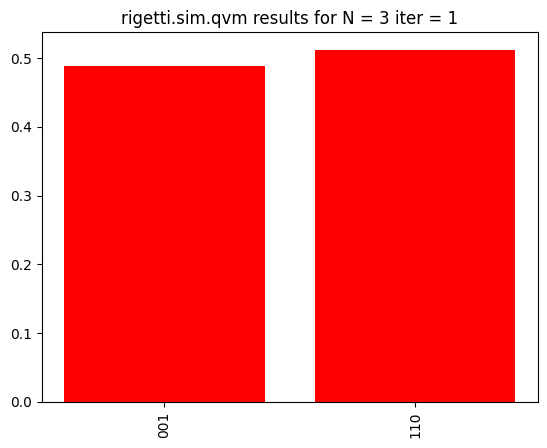

In [19]:
plot_job_results(job.id, iterations, "rigetti.sim.qvm")


### For N =4 (rigetti.sim.qvm)

In [20]:
N = 4
iterations = 6

program = qsharp.compile(f"Grovers({N}, {iterations})")
job = target_rigetti.submit(program, f"Alternating bit pairs (Grover): N={N}, iter={iterations}", shots=1000)


In [21]:
# Once the job is complete, you can fetch its results and print them manually
res = job.get_results()
res


..........

{'[0, 0, 1, 1]': 0.52, '[1, 1, 0, 0]': 0.48}

The cells below allow you to fetch job results based on its ID and plot them, highlighting the results that correspond to the correct answers.

In [22]:
def plot_job_results(jobId, iter, sim):
    # Fetch job results for the given jobId and plot them.
    # "iter" and "sim" parameters are used to make the plot header more descriptive
    job = workspace.get_job(jobId)
    res = job.get_results()
    print(res)

    # Get keys and values, and convert keys from lists of bits to bitstrings
    keys, outputFreq = zip(*sorted(res.items()))
    keys = [key[1:-1].replace(", ", "") for key in keys]
    keyLen = len(keys[0])

    # Generate correct bitstrings
    firstBitString = ""
    secondBitString = ""
    for i in range(keyLen):
        firstBitString += str((i // 2) % 2)
        secondBitString += str(1 - (i // 2) % 2)

    # Find the indices of correct answers in the array of keys
    firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
    secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

    # Plot the frequencies of all keys, with red color marking correct answers and blue - incorrect ones
    plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
    plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
    plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
    plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
    plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
    plt.xticks(rotation=90)
    plt.title("{} results for N = {} iter = {}".format(sim, keyLen, iter))
    plt.show()


{'[0, 0, 1, 1]': 0.52, '[1, 1, 0, 0]': 0.48}


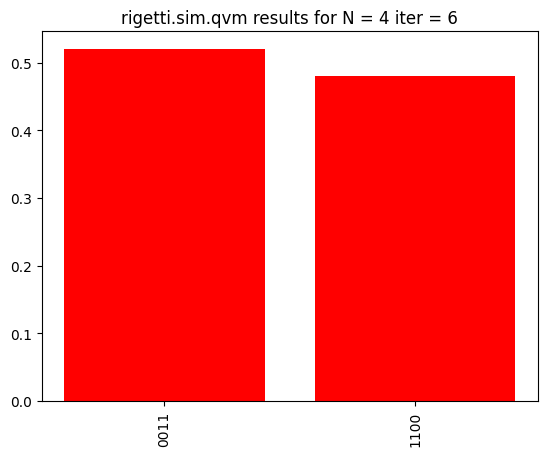

In [23]:
plot_job_results(job.id, iterations, "rigetti.sim.qvm")


### For N =5 (rigetti.sim.qvm)

In [24]:
N = 5
iterations = 15

program = qsharp.compile(f"Grovers({N}, {iterations})")
job = target_rigetti.submit(program, f"Alternating bit pairs (Grover): N={N}, iter={iterations}", shots=1000)


In [25]:
# Once the job is complete, you can fetch its results and print them manually
res = job.get_results()
res


................

{'[0, 0, 1, 1, 0]': 0.501, '[1, 1, 0, 0, 1]': 0.499}

The cells below allow you to fetch job results based on its ID and plot them, highlighting the results that correspond to the correct answers.

In [26]:
def plot_job_results(jobId, iter, sim):
    # Fetch job results for the given jobId and plot them.
    # "iter" and "sim" parameters are used to make the plot header more descriptive
    job = workspace.get_job(jobId)
    res = job.get_results()
    print(res)

    # Get keys and values, and convert keys from lists of bits to bitstrings
    keys, outputFreq = zip(*sorted(res.items()))
    keys = [key[1:-1].replace(", ", "") for key in keys]
    keyLen = len(keys[0])

    # Generate correct bitstrings
    firstBitString = ""
    secondBitString = ""
    for i in range(keyLen):
        firstBitString += str((i // 2) % 2)
        secondBitString += str(1 - (i // 2) % 2)

    # Find the indices of correct answers in the array of keys
    firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
    secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

    # Plot the frequencies of all keys, with red color marking correct answers and blue - incorrect ones
    plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
    plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
    plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
    plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
    plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
    plt.xticks(rotation=90)
    plt.title("{} results for N = {} iter = {}".format(sim, keyLen, iter))
    plt.show()


{'[0, 0, 1, 1, 0]': 0.501, '[1, 1, 0, 0, 1]': 0.499}


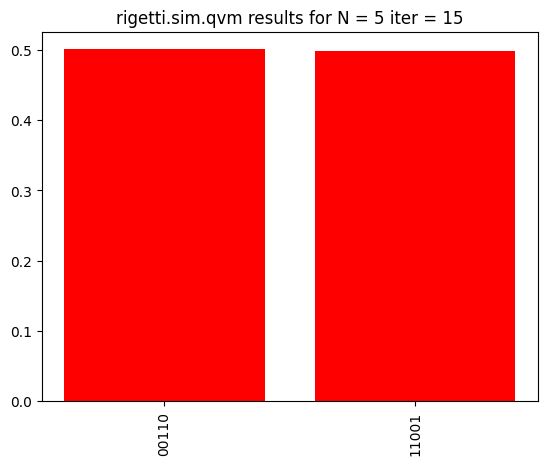

In [27]:
plot_job_results(job.id, iterations, "rigetti.sim.qvm")


## Simulator "quantinuum.sim.h1-1e"

In [19]:
target_quantinuum = workspace.get_targets("quantinuum.sim.h1-1e")

### For N =3 (rigetti.sim.qvm)

In [20]:
N = 3
iterations = 1

program = qsharp.compile(f"Grovers({N}, {iterations})")
job = target_quantinuum.submit(program, f"Alternating bit pairs (Grover): N={N}, iter={iterations}", shots=1000)


In [21]:
# Once the job is complete, you can fetch its results and print them manually
res = job.get_results()
res


...........

{'[0, 0, 1]': 0.474,
 '[1, 1, 0]': 0.471,
 '[0, 1, 0]': 0.008,
 '[0, 0, 0]': 0.005,
 '[1, 0, 0]': 0.011,
 '[1, 0, 1]': 0.007,
 '[0, 1, 1]': 0.008,
 '[1, 1, 1]': 0.016}

The cells below allow you to fetch job results based on its ID and plot them, highlighting the results that correspond to the correct answers.

In [22]:
def plot_job_results(jobId, iter, sim):
    # Fetch job results for the given jobId and plot them.
    # "iter" and "sim" parameters are used to make the plot header more descriptive
    job = workspace.get_job(jobId)
    res = job.get_results()
    print(res)

    # Get keys and values, and convert keys from lists of bits to bitstrings
    keys, outputFreq = zip(*sorted(res.items()))
    keys = [key[1:-1].replace(", ", "") for key in keys]
    keyLen = len(keys[0])

    # Generate correct bitstrings
    firstBitString = ""
    secondBitString = ""
    for i in range(keyLen):
        firstBitString += str((i // 2) % 2)
        secondBitString += str(1 - (i // 2) % 2)

    # Find the indices of correct answers in the array of keys
    firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
    secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

    # Plot the frequencies of all keys, with red color marking correct answers and blue - incorrect ones
    plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
    plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
    plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
    plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
    plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
    plt.xticks(rotation=90)
    plt.title("{} results for N = {} iter = {}".format(sim, keyLen, iter))
    plt.show()


{'[0, 0, 1]': 0.474, '[1, 1, 0]': 0.471, '[0, 1, 0]': 0.008, '[0, 0, 0]': 0.005, '[1, 0, 0]': 0.011, '[1, 0, 1]': 0.007, '[0, 1, 1]': 0.008, '[1, 1, 1]': 0.016}


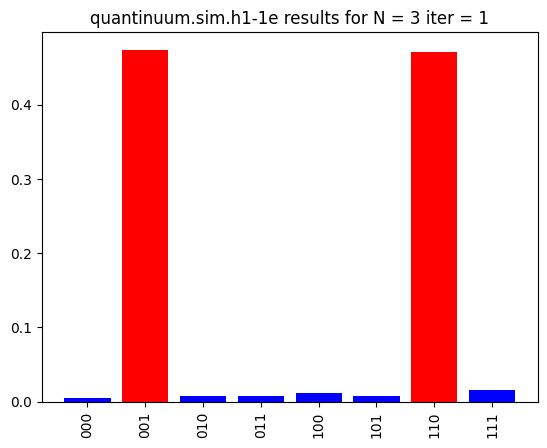

In [23]:
plot_job_results(job.id, iterations, "quantinuum.sim.h1-1e")


### For N =4 (rigetti.sim.qvm)

In [24]:
N = 4
iterations = 6

program = qsharp.compile(f"Grovers({N}, {iterations})")
job = target_quantinuum.submit(program, f"Alternating bit pairs (Grover): N={N}, iter={iterations}", shots=1000)


In [25]:
# Once the job is complete, you can fetch its results and print them manually
res = job.get_results()
res


.................

{'[1, 1, 0, 0]': 0.267,
 '[1, 0, 0, 0]': 0.04,
 '[0, 0, 1, 1]': 0.252,
 '[0, 1, 1, 1]': 0.037,
 '[1, 1, 0, 1]': 0.038,
 '[1, 0, 1, 0]': 0.028,
 '[1, 1, 1, 1]': 0.045,
 '[0, 0, 0, 1]': 0.036,
 '[1, 1, 1, 0]': 0.034,
 '[0, 1, 0, 1]': 0.028,
 '[1, 0, 1, 1]': 0.044,
 '[0, 1, 1, 0]': 0.019,
 '[0, 0, 0, 0]': 0.037,
 '[1, 0, 0, 1]': 0.026,
 '[0, 1, 0, 0]': 0.036,
 '[0, 0, 1, 0]': 0.033}

The cells below allow you to fetch job results based on its ID and plot them, highlighting the results that correspond to the correct answers.

In [26]:
def plot_job_results(jobId, iter, sim):
    # Fetch job results for the given jobId and plot them.
    # "iter" and "sim" parameters are used to make the plot header more descriptive
    job = workspace.get_job(jobId)
    res = job.get_results()
    print(res)

    # Get keys and values, and convert keys from lists of bits to bitstrings
    keys, outputFreq = zip(*sorted(res.items()))
    keys = [key[1:-1].replace(", ", "") for key in keys]
    keyLen = len(keys[0])

    # Generate correct bitstrings
    firstBitString = ""
    secondBitString = ""
    for i in range(keyLen):
        firstBitString += str((i // 2) % 2)
        secondBitString += str(1 - (i // 2) % 2)

    # Find the indices of correct answers in the array of keys
    firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
    secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

    # Plot the frequencies of all keys, with red color marking correct answers and blue - incorrect ones
    plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
    plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
    plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
    plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
    plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
    plt.xticks(rotation=90)
    plt.title("{} results for N = {} iter = {}".format(sim, keyLen, iter))
    plt.show()


{'[1, 1, 0, 0]': 0.267, '[1, 0, 0, 0]': 0.04, '[0, 0, 1, 1]': 0.252, '[0, 1, 1, 1]': 0.037, '[1, 1, 0, 1]': 0.038, '[1, 0, 1, 0]': 0.028, '[1, 1, 1, 1]': 0.045, '[0, 0, 0, 1]': 0.036, '[1, 1, 1, 0]': 0.034, '[0, 1, 0, 1]': 0.028, '[1, 0, 1, 1]': 0.044, '[0, 1, 1, 0]': 0.019, '[0, 0, 0, 0]': 0.037, '[1, 0, 0, 1]': 0.026, '[0, 1, 0, 0]': 0.036, '[0, 0, 1, 0]': 0.033}


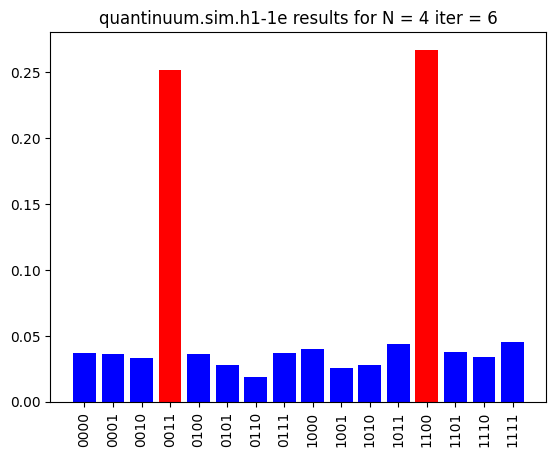

In [27]:
plot_job_results(job.id, iterations, "quantinuum.sim.h1-1e")


### For N =5 (rigetti.sim.qvm)

In [30]:
N = 5
iterations = 3

program = qsharp.compile(f"Grovers({N}, {iterations})")
job = target_quantinuum.submit(program, f"Alternating bit pairs (Grover): N={N}, iter={iterations}", shots=1000)


In [31]:
# Once the job is complete, you can fetch its results and print them manually
res = job.get_results()
res


...................

{'[1, 1, 0, 0, 1]': 0.23,
 '[0, 0, 0, 0, 0]': 0.034,
 '[0, 1, 0, 0, 0]': 0.014,
 '[0, 0, 1, 1, 1]': 0.017,
 '[0, 0, 1, 0, 0]': 0.045,
 '[0, 1, 0, 1, 0]': 0.021,
 '[0, 0, 1, 1, 0]': 0.221,
 '[1, 1, 0, 0, 0]': 0.02,
 '[1, 1, 1, 1, 1]': 0.027,
 '[0, 1, 0, 0, 1]': 0.019,
 '[0, 0, 0, 1, 0]': 0.026,
 '[1, 1, 0, 1, 0]': 0.01,
 '[0, 0, 0, 0, 1]': 0.013,
 '[1, 1, 0, 1, 1]': 0.031,
 '[0, 1, 1, 0, 1]': 0.013,
 '[0, 1, 1, 1, 0]': 0.021,
 '[1, 0, 0, 0, 1]': 0.031,
 '[1, 0, 0, 1, 0]': 0.012,
 '[1, 0, 1, 1, 0]': 0.013,
 '[1, 1, 1, 0, 1]': 0.013,
 '[1, 0, 1, 1, 1]': 0.015,
 '[1, 1, 1, 1, 0]': 0.017,
 '[0, 1, 1, 0, 0]': 0.023,
 '[0, 1, 0, 1, 1]': 0.011,
 '[1, 1, 1, 0, 0]': 0.017,
 '[1, 0, 0, 1, 1]': 0.017,
 '[0, 0, 0, 1, 1]': 0.009,
 '[1, 0, 1, 0, 1]': 0.014,
 '[1, 0, 0, 0, 0]': 0.007,
 '[0, 1, 1, 1, 1]': 0.016,
 '[1, 0, 1, 0, 0]': 0.008,
 '[0, 0, 1, 0, 1]': 0.015}

The cells below allow you to fetch job results based on its ID and plot them, highlighting the results that correspond to the correct answers.

In [32]:
def plot_job_results(jobId, iter, sim):
    # Fetch job results for the given jobId and plot them.
    # "iter" and "sim" parameters are used to make the plot header more descriptive
    job = workspace.get_job(jobId)
    res = job.get_results()
    print(res)

    # Get keys and values, and convert keys from lists of bits to bitstrings
    keys, outputFreq = zip(*sorted(res.items()))
    keys = [key[1:-1].replace(", ", "") for key in keys]
    keyLen = len(keys[0])

    # Generate correct bitstrings
    firstBitString = ""
    secondBitString = ""
    for i in range(keyLen):
        firstBitString += str((i // 2) % 2)
        secondBitString += str(1 - (i // 2) % 2)

    # Find the indices of correct answers in the array of keys
    firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
    secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

    # Plot the frequencies of all keys, with red color marking correct answers and blue - incorrect ones
    plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
    plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
    plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
    plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
    plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
    plt.xticks(rotation=90)
    plt.title("{} results for N = {} iter = {}".format(sim, keyLen, iter))
    plt.show()


{'[1, 1, 0, 0, 1]': 0.23, '[0, 0, 0, 0, 0]': 0.034, '[0, 1, 0, 0, 0]': 0.014, '[0, 0, 1, 1, 1]': 0.017, '[0, 0, 1, 0, 0]': 0.045, '[0, 1, 0, 1, 0]': 0.021, '[0, 0, 1, 1, 0]': 0.221, '[1, 1, 0, 0, 0]': 0.02, '[1, 1, 1, 1, 1]': 0.027, '[0, 1, 0, 0, 1]': 0.019, '[0, 0, 0, 1, 0]': 0.026, '[1, 1, 0, 1, 0]': 0.01, '[0, 0, 0, 0, 1]': 0.013, '[1, 1, 0, 1, 1]': 0.031, '[0, 1, 1, 0, 1]': 0.013, '[0, 1, 1, 1, 0]': 0.021, '[1, 0, 0, 0, 1]': 0.031, '[1, 0, 0, 1, 0]': 0.012, '[1, 0, 1, 1, 0]': 0.013, '[1, 1, 1, 0, 1]': 0.013, '[1, 0, 1, 1, 1]': 0.015, '[1, 1, 1, 1, 0]': 0.017, '[0, 1, 1, 0, 0]': 0.023, '[0, 1, 0, 1, 1]': 0.011, '[1, 1, 1, 0, 0]': 0.017, '[1, 0, 0, 1, 1]': 0.017, '[0, 0, 0, 1, 1]': 0.009, '[1, 0, 1, 0, 1]': 0.014, '[1, 0, 0, 0, 0]': 0.007, '[0, 1, 1, 1, 1]': 0.016, '[1, 0, 1, 0, 0]': 0.008, '[0, 0, 1, 0, 1]': 0.015}


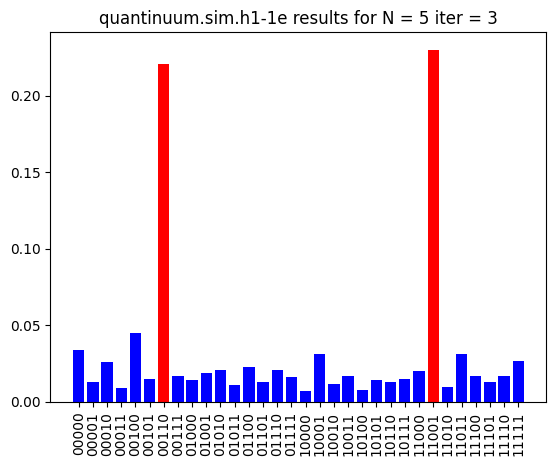

In [33]:
plot_job_results(job.id, iterations, "quantinuum.sim.h1-1e")


## Analysis

The noiseless Rigetti simulation results show outcomes with equal probabilities, indicating perfect amplitude amplification by Grover's algorithm. In contrast, the noisy Quantinuum simulation results display a clear signal for the correct result, but with significant noise evident in other outcomes. This noise reflects real-world quantum computing conditions, where errors can affect computation outcomes.

As problem size increases, the noise impacts would likely become more pronounced, as larger quantum systems are generally more susceptible to error. In such cases, the signal-to-noise ratio may decrease, making it harder to distinguish the correct result from erroneous ones without error mitigation strategies.
